# Preliminary manipulations

In [1]:
import psycopg2 
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# create dictionary to access the database
dict_access = {
        'host': '88.212.254.23',
        'database': 'bw',
        'user': 'user9',
        'password': 'Y7aMlL1x',
        'port': 5432
}

In [3]:
# create function to connect to the PostgreSQL server
def connect(params_dic):
    conn = None
    try:
        # connect to the PostgreSQL server
        conn = psycopg2.connect(**params_dic)
    except (Exception, psycopg2.DatabaseError) as error:
        # in case of error print error
        print(error)
    print("Connection successful")
    return conn
# connect to the PostgreSQL server
conn = connect(dict_access)

Connection successful


In [4]:
# construct an engine connection string
engine_string = "postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}".format(
    user = dict_access['user'],
    password = dict_access['password'],
    host = dict_access['host'],
    port = dict_access['port'],
    database = dict_access['database'],
)

# create sqlalchemy engine
engine = create_engine(engine_string)


In [5]:
# get the names of all public tables in the database
path = "SELECT table_schema, table_name FROM information_schema.tables WHERE ( table_schema = 'public' ) ORDER BY table_schema, table_name;"
cursor = conn.cursor()
cursor.execute(path)
list_tables = cursor.fetchall()

In [6]:
# create a dictionary with keys equal to table names and values equal to the coressponding pandas dataframes
tables_to_use = {}
for i in range(len(list_tables)):
    tables_to_use[list_tables[i][1]] = pd.read_sql_table(list_tables[i][1], engine)


# 1.Sales dynamics

In [7]:
# use table 'orders' to find out sales dynamics patterns by year
orders_y = tables_to_use['orders'].copy()
orders_y = orders_y.sort_values('order_date')
orders_y['year'] = orders_y['order_date'].dt.year
# use only 'sales' and 'year' column
orders_overall_y = orders_y[['sales', 'year']]
# sum sales over years
ord_by_y = orders_overall_y.pivot_table('sales', index = 'year', aggfunc=np.sum)

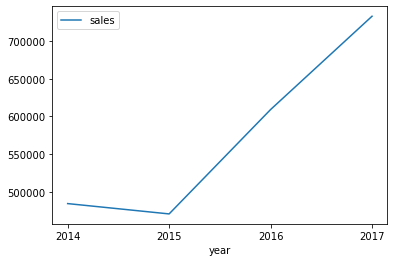

In [8]:
# plot sales over years
ord_by_y.plot()
plt.xticks(np.arange(2014,2018,1))
plt.show()


# Analysis
Sales slightly decreased (-3%) in 2015 with respect to the previous year. In all other years sales robustly increased (2016: +29%, 2017: +20%).
Overall, over the timespan there is a strong upward sales dynamics trend.

In [9]:
# use table 'ordres' to find out sales dynamics patterns by quarters
orders_q = tables_to_use['orders'].copy()
orders_q = orders_q.sort_values('order_date')
orders_q['quarter'] = orders_q['order_date'].dt.year.astype(str) + 'Q' + orders_q['order_date'].dt.quarter.astype(str)
# use only 'sales' and 'quartres' column
orders_overall_q = orders_q[['sales', 'quarter']]
# sum sales over quarters
ord_by_q = orders_overall_q.pivot_table('sales', index = 'quarter', aggfunc=np.sum)

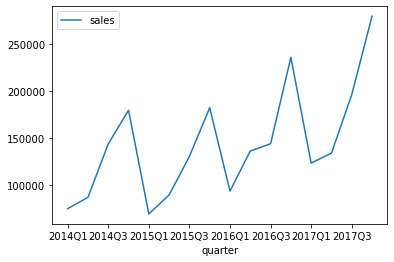

In [10]:
# plot slaes over quarters
ord_by_q.plot()
plt.show()

# Analysis
Quarter sales dynamics reveals strong seasonality patterns: sales tend to increase from Q1 to Q4 and then drop. Overall, quarter dynamics confirms yearly upward trend: Q4 maximums and Q1 minimums tend to rise with time.

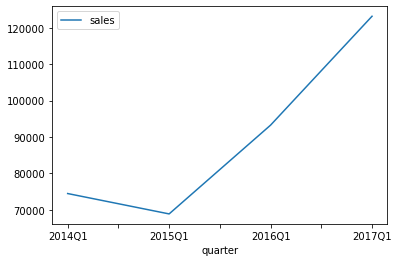

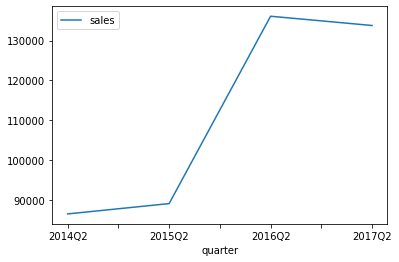

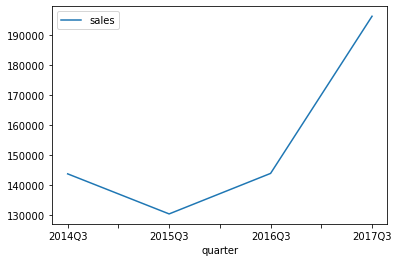

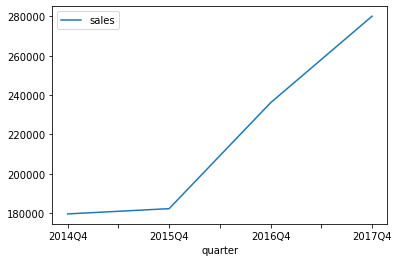

In [11]:
# plot sales dynamics quarter to quarter
q1 = ord_by_q.iloc[[0,4,8,12]]
q2 = ord_by_q.iloc[[1,5,9,13]]
q3 = ord_by_q.iloc[[2,6,10,14]]
q4 = ord_by_q.iloc[[3,7,11,15]]
q1.plot()
q2.plot()
q3.plot()
q4.plot()
plt.show()

# Analysis
Quarter to quarter results in general confirm the conclusions from preceding analysis. One interesting feature is that in 2017Q2 sales actually slightly dropped with respect to 2016Q2, whereas overall yearly sales in 2017 showed 20% increase with respect to 2016.

# 2.Average check dynamics

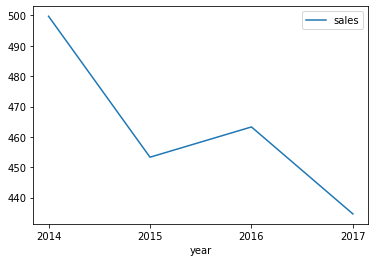

In [14]:
# average sales over years
check_by_y = orders_overall_y.pivot_table('sales', index = 'year', aggfunc=np.mean)
# plot average sales over years
check_by_y.plot()
plt.xticks(np.arange(2014,2018,1))
plt.show()

# Analysis
While overall sales are increasing, average check is decreasing with time: even though in 2016 average check rose with respect to 2015, in 2017 average check plunged even deeper below historical minimimum of 2015

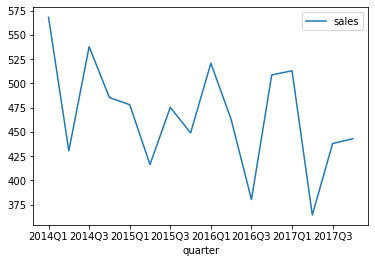

In [15]:
# average sales over quarters
check_by_q = orders_overall_q.pivot_table('sales', index = 'quarter', aggfunc=np.mean)
# plot average slaes over quarters
check_by_q.plot()
plt.show()

# Analysis
Seasonality in average sales dynamics is not that striking, though some patterns still can be observed: local maximums in 3 out of 4 years appeared in Q1 (2014, 2016, 2017), while local minimums in 3 out of 4 years appeered in Q2 (2014, 2015, 2017).
All in all, since there is a trend towards decreasing local minimums and local maximums, one can state that average check is decreasing with time.    

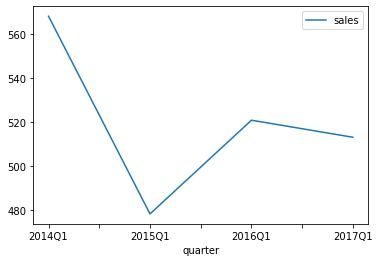

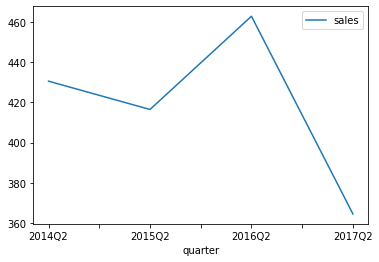

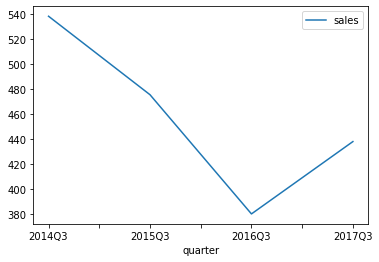

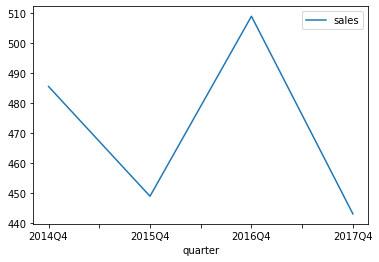

In [16]:
# plot average sales dynamics quarter to quarter
q1_c = check_by_q.iloc[[0,4,8,12]]
q2_c = check_by_q.iloc[[1,5,9,13]]
q3_c = check_by_q.iloc[[2,6,10,14]]
q4_c = check_by_q.iloc[[3,7,11,15]]
q1_c.plot()
q2_c.plot()
q3_c.plot()
q4_c.plot()
plt.show()

# Analysis
Quarter to quarter analysis in general confirms the previous results. One holistic conclusion after analysis of sales and average check is as follows: 1) in 2016 overall sales enjoyed significant increase, which continued in 2017, though year-to-year percantage increase diminished in 2017; 2) the lower sales increase in 2017 with respect to 2016 may be attributable to decreased average check.

Quarter to quarter average check analysis also reveals that 2017Q2 drop in sales with respect to 2016Q2 can be partially explained by substantial decrease in 2017Q2 average check (-22%): presumamble increase in the number of orders did not compensate for decrease in average check.   
    

# 3.1. General categories analysis

In [17]:
# use table 'line_items' to find out category sales dynamics
line_items = tables_to_use['line_items'].copy()
# add some columns to represent order year, category and sub_category
line_items['year'] = line_items.apply(lambda row: row['order_id'][3:7], axis=1)
line_items['category'] = line_items.apply(lambda row: row['product_id'][:3], axis=1)
# get yearly sales for each category
cat_piv = line_items.pivot_table('amount', index = 'year', columns = 'category', aggfunc=np.sum, margins = True)

In [18]:
# calculate percentage for each category each year
col_list = list(cat_piv.columns)
name_list = ['FUR_p', 'OFF_p', 'TEC_p']
for i in range(len(name_list)):
    cat_piv[name_list[i]] = cat_piv[col_list[i]]/cat_piv['All']
print(cat_piv)

category          FUR         OFF         TEC           All     FUR_p  \
year                                                                    
2014      156911.4811  151776.412  175278.233  4.839661e+05  0.324220   
2015      170518.2370  137143.403  162780.809  4.704424e+05  0.362464   
2016      198615.0560  183415.790  225769.844  6.078007e+05  0.326777   
2017      215387.2692  245982.187  271930.851  7.333003e+05  0.293723   
All       741432.0433  718317.792  835759.737  2.295510e+06  0.322992   

category     OFF_p     TEC_p  
year                          
2014      0.313610  0.362170  
2015      0.291520  0.346016  
2016      0.301770  0.371454  
2017      0.335445  0.370831  
All       0.312923  0.364085  


# Analysis
In general, sales are distributed pretty equally between 3 common categories (Office Supplies, Furniture and Technology). At the same time, the proportion of Furniture sales tends to decrease from year 2015, while Office Supplies sales proportion increases from 2015. In 2016 and 2017 Technology sales accounted for the largest part in overall sales.

# 3.2. Subcategories analysis

In [19]:
# see subcategory in detail
products = tables_to_use['products'].copy()
print(products.sub_category.unique())

['Storage' 'Supplies' 'Accessories' 'Copiers' 'Machines' 'Phones' 'Chairs'
 'Bookcases' 'Furnishings' 'Tables' 'Appliances' 'Art' 'Binders'
 'Envelopes' 'Fasteners' 'Labels' 'Paper']


In [20]:
# now let see subcategory sales dynamics
line_items['sub_category'] = line_items.apply(lambda row: row['product_id'][:6], axis=1)
# get yearly sales for each subcategory
subcat_piv = line_items.pivot_table('amount', index = 'sub_category', columns = 'year', aggfunc=np.sum, margins = True)
# find 5 subcategories with largest sales over all 4 years
top_5 = subcat_piv.sort_values('All', ascending = False).iloc[:6]
top_5_list = list(top_5.index)[1:]
# print top_5
print(top_5_list)

['TEC-PH', 'FUR-CH', 'OFF-ST', 'FUR-TA', 'OFF-BI']


In [21]:
# see top_5 subcategories in year 2017
list(subcat_piv.sort_values('2017', ascending = False).iloc[:6].index)[1:]

['TEC-PH', 'FUR-CH', 'OFF-BI', 'OFF-ST', 'TEC-CO']

In [22]:
# print each category sales ranked by total category sales over 4 years in descending order
print(subcat_piv.sort_values('All', ascending = False))

year                 2014         2015         2016         2017           All
sub_category                                                                  
All           483966.1261  470442.4490  607800.6900  733300.3072  2.295510e+06
TEC-PH         77390.8060   68313.7020   78659.6540  105642.8920  3.300071e+05
FUR-CH         76960.2040   71734.5290   83918.6450   95554.3530  3.281677e+05
OFF-ST         50329.0420   45048.2480   58632.1880   69289.7500  2.232992e+05
FUR-TA         46088.3655   39150.4235   60833.2005   60893.5425  2.069655e+05
OFF-BI         43488.2650   37363.0380   49485.1810   72986.1890  2.033227e+05
TEC-MA         62023.3730   27763.6970   55906.8860   43544.6750  1.892386e+05
TEC-AC         25014.2720   40523.9600   41603.8940   59843.8960  1.669860e+05
TEC-CO         10849.7820   26179.4500   49599.4100   62899.3880  1.495280e+05
FUR-BO         20036.6776   38543.5725   26275.4665   30024.2797  1.148800e+05
OFF-AP         15313.6250   23241.2890   26050.3150 

# Analysis
Over all 4 years major sales drivers were Phones, Chairs, Storage, Tables and Binders items. Their proportion in total sales ranges from 14,4% (Phones) to 8,8% (Binders).
If we consider sales in 2017 only, Copiers replaced Tables in top_5 list: Copiers sales rose from 10850 in 2014 to 62899 in 2017 (+480%).

# 4. Last 3 months analysis

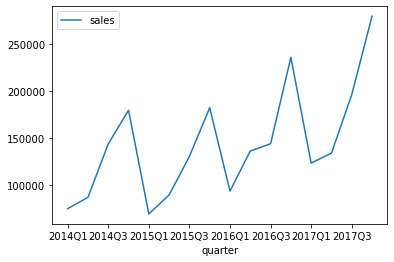

In [23]:
# print quarter sales dynamics
ord_by_q.plot()
plt.show()

Lets look at the plot showing sales by quarter. As stated earlier, quarter sales are subject to seasonality: sales tend to grow from Q1 to Q4 and then drop. In this sense there is no anomaly that in 2017Q4 sales were higher than in other quarters of this year.
The fact that 2017Q4 sales exceeded sales of 2016Q4 is not anomalous either: we saw earlier that for the last two years overall sales tend to increase and 2017Q1 minimum is higher that that of 2016Q1.    

Also we know that average check in all quarters of 2017 except for Q3 was lower than in 2016. So it is inevitable that the number of orders increased in 2017, including 2017Q4. All in all, one can assume that sales dynamics in the last three months, i.e. 2017Q4, is driven by seasonality (people make intensive purchases before Christmas) and rising number of new customers (business expands and new customers are covered). 

Now lets see sales dynamics in each month of the quarter, segmenting sales by categories and customers.

In [24]:
# find out sales dynamics in each month of Q4 in each year
list_q = ['2014Q4', '2015Q4', '2016Q4', '2017Q4']
for i in range(len(list_q)):
    orders_q4 = orders_q[orders_q['quarter'] == list_q[i]].copy()
    orders_q4['month'] = orders_q4.order_date.dt.month
    print(orders_q4.pivot_table('sales', index = 'month', aggfunc=np.sum, margins = True))
    


             sales
month             
10      31453.3930
11      78628.7167
12      69545.6205
All    179627.7302
             sales
month             
10      31404.9235
11      75972.5635
12      74919.5212
All    182297.0082
             sales
month             
10      59687.7450
11      79411.9658
12      96999.0430
All    236098.7538
             sales
month             
10      77776.9232
11     118447.8250
12      83829.3188
All    280054.0670


Comparing patterns through the years we see that in general sales in November and December were about of the same size and exceded sales in October.
However, in 2017 sales in November substantially exceeded sales in October and December.

In [25]:
# compare subcategory sales in Q4 in each year
list_q = ['2014Q4', '2015Q4', '2016Q4', '2017Q4']
for i in range(len(list_q)):
    orders_q4 = orders_q[orders_q['quarter'] == list_q[i]].copy()
    orders_q4['month'] = orders_q4.order_date.dt.month
    names = list(orders_q4['id'].values)
    categories = line_items[line_items['order_id'].isin(names)]
    print(categories.pivot_table('amount', index = 'sub_category', aggfunc=np.sum, margins = True).sort_values('amount', ascending = False).head(15))

                   amount
sub_category             
All           179627.7302
TEC-PH         35642.0360
FUR-CH         31004.1330
OFF-ST         20959.5660
FUR-TA         17392.8410
TEC-MA         13308.7040
OFF-BI         11245.4760
FUR-BO         10935.0542
TEC-AC         10341.9540
OFF-PA          6800.3180
OFF-AP          6089.9840
FUR-FU          5183.0580
TEC-CO          3739.9240
OFF-AR          2632.2500
OFF-EN          1868.5160
                   amount
sub_category             
All           182297.0082
FUR-CH         30123.6750
TEC-PH         24142.9360
TEC-AC         20800.1000
FUR-TA         15969.0020
TEC-MA         14857.6890
OFF-ST         14041.5560
FUR-BO         13203.3582
OFF-AP         11189.1710
TEC-CO         10409.7940
OFF-BI          8669.9050
FUR-FU          6697.2400
OFF-PA          6509.8780
OFF-AR          2211.9500
OFF-EN          1892.3120
                   amount
sub_category             
All           235812.3738
FUR-CH         34034.5940
OFF-BI      

Comparing Q4 sales in 2017 and 2016 we see that there is a significant upside for Phones, Tables, Copies and Machines sales in 2017Q4.

In [26]:
# find the number of new customers in 2017Q4
orders_q4 = orders_q[orders_q['quarter'] == '2017Q4'].copy()
q4_cust = set(orders_q4.customer_id.unique())
prev_cust = set(orders_q[orders_q['quarter'] != '2017Q4'].copy().customer_id.unique())
new_cust = len(q4_cust) - len(q4_cust&prev_cust)
print(new_cust)

3


In [27]:
# calculate how much new custumers added to total sales in Q4
sum = 0
for i in range (len(list(q4_cust.difference(q4_cust&prev_cust)))):
    sum += orders_y[orders_y['customer_id'] == list(q4_cust.difference(q4_cust&prev_cust))[i]].sales.sum()
print(sum)

2799.112


In [28]:
# find the number of new customers in 2017 who made purchases in 2017Q4
orders_q4 = orders_q[orders_q['quarter'] == '2017Q4'].copy()
q4_cust = set(orders_q4.customer_id.unique())
prev_cust = set(orders_y[orders_y['year'] != 2017].copy().customer_id.unique())
new_cust = len(q4_cust) - len(q4_cust&prev_cust)
print(new_cust)

6


The assumption about significant number of new customers in 2017Q4 was wrong: sales were driven by intensive purchasing activity of previous customers

In [29]:
# find out largest sales in Q4 by customers
orders_q4 = orders_q[orders_q['quarter'] == '2017Q4'].copy()
print(orders_q4.pivot_table('sales', index = 'customer_id', aggfunc=np.sum, margins = True).sort_values('sales', ascending = False).head(11))

                  sales
customer_id            
All          280054.067
TA-21385      13716.458
HL-15040      10522.550
GT-14635       8167.420
TS-21370       6492.314
JW-15220       5384.548
KH-16510       4021.235
TT-21070       3813.166
RB-19795       3693.760
Dp-13240       3464.882
AC-10450       3459.600


In [30]:
# find out the items purchased by 3 largest customers
ids = list(orders_q4.pivot_table('sales', index = 'customer_id', aggfunc=np.sum, margins = True).sort_values('sales', ascending = False).head(4).index)[1:]
line_items[line_items['order_id'].isin(list(orders_q4[orders_q4['customer_id'].isin(ids)].id))]

,order_id,product_id,amount,quantity,year,category,sub_category
681,US-2017-168116,TEC-MA-10004125,7999.980,4,2017,TEC,TEC-MA
682,US-2017-168116,OFF-AP-10002457,167.440,2,2017,OFF,OFF-AP
2620,CA-2017-127180,TEC-CO-10004722,11199.968,4,2017,TEC,TEC-CO
2621,CA-2017-127180,TEC-PH-10001494,2399.600,8,2017,TEC,TEC-PH
2622,CA-2017-127180,OFF-EN-10002500,63.900,5,2017,OFF,OFF-EN
2623,CA-2017-127180,TEC-PH-10003800,52.990,1,2017,TEC,TEC-PH
2974,CA-2017-134607,OFF-ST-10002214,22.580,2,2017,OFF,OFF-ST
4185,CA-2017-166709,TEC-CO-10004722,10499.970,3,2017,TEC,TEC-CO


Now we see that orders of 3 most active customers in 2017Q4 constitute mostly of Copiers, Machines and Phones. Lets see largest sales in 2016Q4 for comparison.

In [31]:
orders_q4_2016 = orders_q[orders_q['quarter'] == '2016Q4'].copy()
orders_q4_2016.pivot_table('sales', index = 'customer_id', aggfunc=np.sum, margins = True).sort_values('sales', ascending = False).head(11)

,sales
customer_id,
All,236098.7538
TC-20980,18344.0520
AB-10105,9892.7400
DR-12940,5791.5860
CS-12505,5068.6850
JE-15715,5008.6580
DP-13390,4685.0760
GK-14620,4669.5240
JD-15895,4494.3400


In 2016Q4 there were also very large orders, so there is no anomaly in 2017Q4. Sales dynamics in 2017Q4 is driven neither by new customers nor by some large anomolous orders.

<BarContainer object of 16 artists>

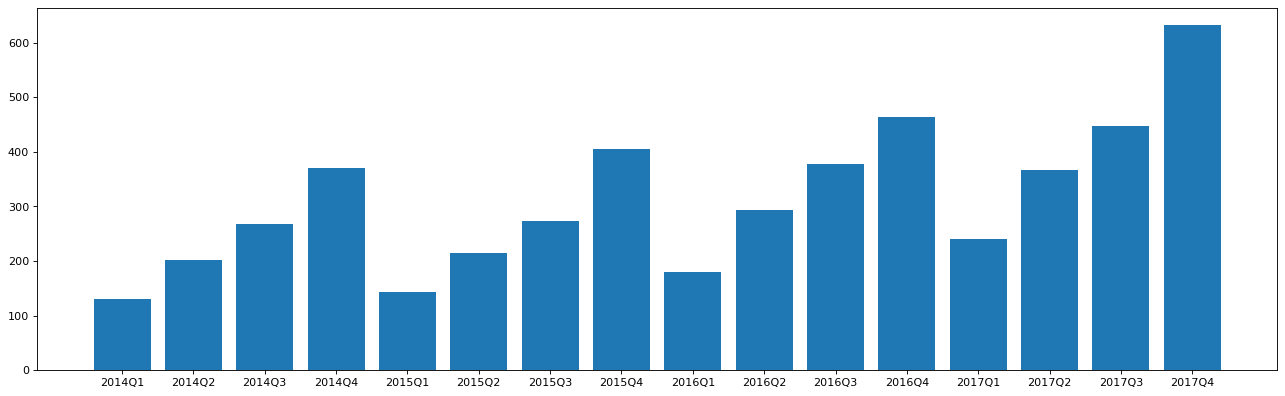

In [32]:
# find out the number of orders in each quarter
from collections import Counter
labels, values = zip(*(Counter(orders_q.quarter)).items())
plt.figure(figsize=(20, 6), dpi=80)
plt.bar(labels, values)

Figure shows the number of orders in each quarter. It is evident that in 2017 the number of orders significantly increased with Q4 number being the historical maximum.

# Final words

In [33]:
orders_q4 = orders_q[orders_q['quarter'] == '2017Q4'].copy()
orders_q4['month'] = orders_q4.order_date.dt.month
print(orders_q4.pivot_table('sales', index = 'month', aggfunc=np.sum, margins = True))
    

             sales
month             
10      77776.9232
11     118447.8250
12      83829.3188
All    280054.0670


This table presents sales dynamics in last three months. 

Macrofactors.

As we showed, quarter sales dynamics is subject to seasonality, so one reason for these figures to be larger than that of previos quarters in this year is the fact that sales tends to boost in the last quarter of the year.
Another reason lies in the order number dynamics: the number of orders in the last three months significantly increased even with respect to 2016Q4. This means that the rise in 2017Q4 sales is attributable not only to seasonality, but also to overall busienss expansion. The increase in the number of orders in 2017Q4 is indeed striking, taking into account the fact that average check fell in 2017, while sales rose.

Microfactors.

As we showed, neither new customers nor any exceptional volume order affected sales in 2017Q4: numbers are in favour of structural inrease in sales by old customers. Items such as Phones, Tables, Copiers and Machines took the sales lead increase in 2017Q4.

# Some note

When I calculate overall sales volume using table 'orders' and  table 'line_items' final sales a little bit diverge for some reason. But the difference is not significant and can not lead to different qualitive results.